In [1]:
# Importing everything 
import gzip
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
##################
import time
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
##########################
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy import misc
from torch.utils.data import Dataset, DataLoader
##################
from pytorchtools import EarlyStopping


In [2]:
import torch
from torchvision import datasets, transforms
# import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('/F_MNIST_data/', download=True, train=True, transform=transform)

testset = datasets.FashionMNIST('/F_MNIST_data/', download=True, train=False, transform=transform)


In [3]:
train_set, val_set = torch.utils.data.random_split(trainset, [50000, 10000])
trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

In [4]:
n_Samples_train = len(train_set)
n_Samples_val   = len(val_set)
n_Samples_test  = len(testset)


In [5]:
# make a fully connected network using pytorch 
# start with one hidden layer and variable number of nodes.
class MLP_Net(nn.Module):
    def __init__(self, nhidden=10):
        super(MLP_Net, self).__init__()
        ### The layers
        self.fc1 = nn.Linear(28*28, nhidden)
        self.bn1 = nn.BatchNorm1d(num_features=nhidden)
        self.fc2 = nn.Linear(nhidden, 10 )
### feedfoward
    def forward(self, images):
        x = images.view(-1,28*28)
        x = self.bn1(torch.sigmoid(self.fc1(x)))
        x = self.fc2(x)
        return F.softmax(x, dim =1)

In [24]:
######################### WORK ON THIS OCTOBER 29
def Train_model_1HiddenLayer(nhidden, n_epochs, losscriterion , learningrate):
    ########## Early stopping has to be initialized at the beginning of every training #########
    early_stopping = EarlyStopping(patience=20, verbose=True)
    # Initializing the arrays to store the results 
    
    train_loss = torch.zeros(n_epochs)
    train_acc  = torch.zeros(n_epochs)
    val_loss   = torch.zeros(n_epochs)
    val_acc    = torch.zeros(n_epochs)
#     train_time = torch.zeros(n_epochs)    
    # Creating an instance of the model
    net = MLP_Net(nhidden)
    params = net.parameters()
    optimizer = optim.Adam(params = params, lr = learningrate)
    # 
    
    start = time.time()
    for epoch in range(n_epochs):  # loop over the dataset multiple times
#         print('Training Epoch', epoch)


        running_loss = 0.0
        
#         s = 0 # batch counter 
        val_batch_acc   = 0 
        train_batch_acc = 0
        #TRAINING
        for i, data in enumerate(trainloader):
            inputs, labels = data
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            #back propagation
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_batch_preds = torch.argmax(outputs, axis = 1)
            train_batch_acc += len(torch.where(train_batch_preds == labels)[0])

        ###
        train_loss[epoch] = running_loss/(i+1)
        train_acc[epoch] = train_batch_acc/n_Samples_train

        net.eval()

        #VALIDATION
        val_runningloss = 0.0
        for j, dataval in enumerate(valloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs_val, labels_val = dataval
            val_pred = net(inputs_val)
            val_batch_preds = torch.argmax(val_pred, axis = 1)
            val_batch_acc += len(torch.where(val_batch_preds == labels_val)[0])
            
            with torch.no_grad():
                loss_val = criterion(val_pred, labels_val)
                val_runningloss += loss_val.item()
                
        val_Loss_Epoch = val_runningloss/(j+1)
        val_loss[epoch] = val_Loss_Epoch
        val_acc[epoch] = val_batch_acc/n_Samples_val
        #             early_stopping needs the validation loss to check if it has decresed, 
    #         and if it has, it will make a checkpoint of the current model
        early_stopping(val_Loss_Epoch, net)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        #calculating time
        #
    ### TESTING 
    test_batch_acc = 0.0
    test_running_loss = 0.0
    for k, datatest in enumerate(testloader):
        inputs_test , labels_test = datatest
        test_pred = net(inputs_test)
        test_batch_pred = torch.argmax(test_pred, axis = 1)
        test_batch_acc  += len(torch.where(test_batch_pred == labels_test)[0])
        loss_test = criterion(test_pred, labels_test)
        test_running_loss +=loss_test.item()
    #
    test_acc = test_batch_acc/n_Samples_test
    test_loss = test_running_loss/(k+1)
        
        
     
    end = time.time()
    interval = end - start
    train_time = interval/60
    ResultDict = {'TrainLoss' : train_loss[np.nonzero(train_loss)], 
                 'TrainAcc' : train_acc[np.nonzero(train_acc)],
                 'ValLoss': val_loss[np.nonzero(val_loss)],
                 'ValAcc' : val_acc[np.nonzero(val_acc)],
                 'TestLoss': test_loss,
                 'TestAcc': test_acc,
                 'TrainTime': train_time}
    return ResultDict

In [120]:
x = np.array([1,1,4,0,4])
x[np.nonzero(x)]

array([1, 1, 4, 4])

In [122]:
# Try the function -- Good that works . 
# early_stopping = EarlyStopping(patience=20, verbose=True)
criterion = nn.CrossEntropyLoss()
learningrate = .001
n_epochs = 500
nhidden = 50 

In [80]:
Train_model_1HiddenLayer(nhidden, n_epochs, criterion , .01)

Validation loss decreased (inf --> 1.670307).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (1.670307 --> 1.655602).  Saving model ...
EarlyStopping counter: 1 out of 20


{'TrainLoss': tensor([1.6823, 1.6577, 1.6582, 1.6533, 1.6548]),
 'TrainAcc': tensor([0.7894, 0.8041, 0.8031, 0.8081, 0.8059]),
 'ValLoss': tensor([1.6703, 1.6709, 1.6715, 1.6556, 1.6564]),
 'ValAcc': tensor([0.7929, 0.7895, 0.7863, 0.8048, 0.8050]),
 'TestLoss': 1.6587775432610814,
 'TestAcc': 0.8007,
 'TrainTime': 0.8386032064755757}

In [123]:
## Make the loop for the hidden nodes. 
nhidden_arr = [30, 40, 50, 60, 70, 100, 120, 150, 200]
# early_stopping = EarlyStopping(patience=20, verbose=True)
criterion = nn.CrossEntropyLoss()
learningrate = .001
n_epochs = 500

In [124]:
# How to organize the results \dic_nh_ES = defaultdict(lambda: "Not Present") 
##### Run this 
from collections import defaultdict

dic_nodes_1hd = defaultdict(lambda: "Not Present") 
nnh = len(nhidden_arr)
for ii in range(nnh): 
    nhidden = nhidden_arr[ii]
    key = str(nhidden)
    print('nhidden = ', key)
    results = Train_model_1HiddenLayer(nhidden, n_epochs, criterion , learningrate)
#     print('adding to dictionary')
    dic_nodes_1hd[key] = results
#     print(dic_nodes_1hd)

nhidden =  30
Validation loss decreased (inf --> 1.652217).  Saving model ...
Validation loss decreased (1.652217 --> 1.624327).  Saving model ...
Validation loss decreased (1.624327 --> 1.616839).  Saving model ...
Validation loss decreased (1.616839 --> 1.611615).  Saving model ...
Validation loss decreased (1.611615 --> 1.608827).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (1.608827 --> 1.602685).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (1.602685 --> 1.600455).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (1.600455 --> 1.597235).  Saving model ...
Validation loss decreased (1.597235 --> 1.596624).  Saving model ...
Validation loss decreased (1.596624 --> 1.594450).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (1.594450 --> 1.592092).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (1.592092 --> 1.586875).  Savin

C:\Users\skypi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:58: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  return bound(*args, **kwds)


adding to dictionary
defaultdict(<function <lambda> at 0x000001F7167A4D38>, {'30': {'TrainLoss': tensor([[1.7256],
        [1.6293],
        [1.6141],
        [1.6066],
        [1.6018],
        [1.5971],
        [1.5935],
        [1.5910],
        [1.5876],
        [1.5844],
        [1.5816],
        [1.5806],
        [1.5776],
        [1.5764],
        [1.5729],
        [1.5726],
        [1.5706],
        [1.5685],
        [1.5682],
        [1.5665],
        [1.5657],
        [1.5646],
        [1.5624],
        [1.5611],
        [1.5601],
        [1.5590],
        [1.5579],
        [1.5584],
        [1.5573],
        [1.5568],
        [1.5544],
        [1.5533],
        [1.5528],
        [1.5521],
        [1.5509],
        [1.5515],
        [1.5511],
        [1.5495],
        [1.5499],
        [1.5483],
        [1.5480],
        [1.5472],
        [1.5464],
        [1.5465],
        [1.5466],
        [1.5461],
        [1.5458],
        [1.5443],
        [1.5448],
        [1.5435],
   

In [142]:
# {'TrainLoss' : train_loss[np.nonzero(train_loss)], 
#                  'TrainAcc' : train_acc[np.nonzero(train_acc)],
#                  'ValLoss': val_loss[np.nonzero(val_loss)],
#                  'ValAcc' : val_acc[np.nonzero(val_acc)],
#                  'TestLoss': test_loss,
#                  'TestAcc': test_acc,
#                  'TrainTime': train_time}

Train_Loss_matrix = -1*torch.ones(nnh, n_epochs)
Train_Acc_matrix = -1*torch.ones(nnh, n_epochs)
Val_Loss_matrix = -1*torch.ones(nnh, n_epochs)
Val_Acc_matrix = -1*torch.ones(nnh, n_epochs)
EpochsArr = torch.zeros(nnh)
TestAccArr = torch.zeros(nnh)
TestLossArr = torch.zeros(nnh)
TrainTimeArr = torch.zeros(nnh)
for ii in range(nnh):
    nh = nhidden_arr[ii]
    key = str(nh)
    epochstrained = len(dic_nodes_1hd[key]['TrainAcc'])
    EpochsArr[ii] = epochstrained
    Train_Loss_matrix[ii,:epochstrained] = torch.reshape(dic_nodes_1hd[key]['TrainLoss'],(1,epochstrained))
    Train_Acc_matrix[ii,:epochstrained] = torch.reshape(dic_nodes_1hd[key]['TrainAcc'],(1,epochstrained))
    Val_Loss_matrix[ii,:epochstrained] =torch.reshape(dic_nodes_1hd[key]['ValLoss'],(1,epochstrained))
    Val_Acc_matrix[ii,:epochstrained] =torch.reshape(dic_nodes_1hd[key]['ValAcc'],(1,epochstrained))
    TestAccArr[ii] = dic_nodes_1hd[key]['TestAcc']
    TestLossArr[ii] = dic_nodes_1hd[key]['TestLoss']
    TrainTimeArr[ii] = dic_nodes_1hd[key]['TrainTime']

In [143]:
dictionary = defaultdict(lambda: "Not Present") 
for k in range(3):
    dictionary[str(k)] = {10: k}

In [144]:
len( dic_nodes_1hd[key]['TrainLoss'])

101

In [145]:
Train_Loss_matrix

tensor([[ 1.7256,  1.6293,  1.6141,  ..., -1.0000, -1.0000, -1.0000],
        [ 1.7076,  1.6287,  1.6147,  ..., -1.0000, -1.0000, -1.0000],
        [ 1.6961,  1.6284,  1.6134,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [ 1.6657,  1.6265,  1.6107,  ..., -1.0000, -1.0000, -1.0000],
        [ 1.6632,  1.6285,  1.6102,  ..., -1.0000, -1.0000, -1.0000],
        [ 1.6574,  1.6292,  1.6125,  ..., -1.0000, -1.0000, -1.0000]])

In [146]:
torch.save(Train_Loss_matrix, 'Train_Loss_matrix_1layer_manyNodes')
torch.save(Train_Acc_matrix,'Train_Acc_matrix_1layer_manyNodes')
torch.save(Val_Loss_matrix,'Val_Loss_matrix_1layer_manyNodes')
torch.save(Val_Acc_matrix,'Val_Acc_matrix_1layer_manyNodes')
torch.save(TestLossArr,'TestLossArr_1layer_manyNodes')
torch.save(TestAccArr,'TestAccArr_1layer_manyNodes')
torch.save(TrainTimeArr,'TrainTimeArr_1layer_manyNodes')


In [9]:
Train_Loss_Mat = torch.load('Train_Loss_matrix_1layer_manyNodes')
Train_Acc_Mat = torch.load('Train_Acc_matrix_1layer_manyNodes')
Val_Loss_Mat = torch.load('Val_Loss_matrix_1layer_manyNodes')
Val_Acc_Mat = torch.load('Val_Acc_matrix_1layer_manyNodes')
Test_Loss_Arr = torch.load('TestLossArr_1layer_manyNodes')
Test_Acc_Arr = torch.load('TestAccArr_1layer_manyNodes')
Train_Time_Arr = torch.load('TrainTimeArr_1layer_manyNodes')

In [15]:
Val_Loss_Mat[1,[Val_Loss_Mat[1,:]>0][0]].shape

torch.Size([80])

In [18]:
test_acc_diff_nhidden = Test_Acc_Arr[Test_Acc_Arr>0]
test_acc_diff_nhidden

tensor([0.8723, 0.8727, 0.8725, 0.8727, 0.8745, 0.8796, 0.8816, 0.8776, 0.8763])

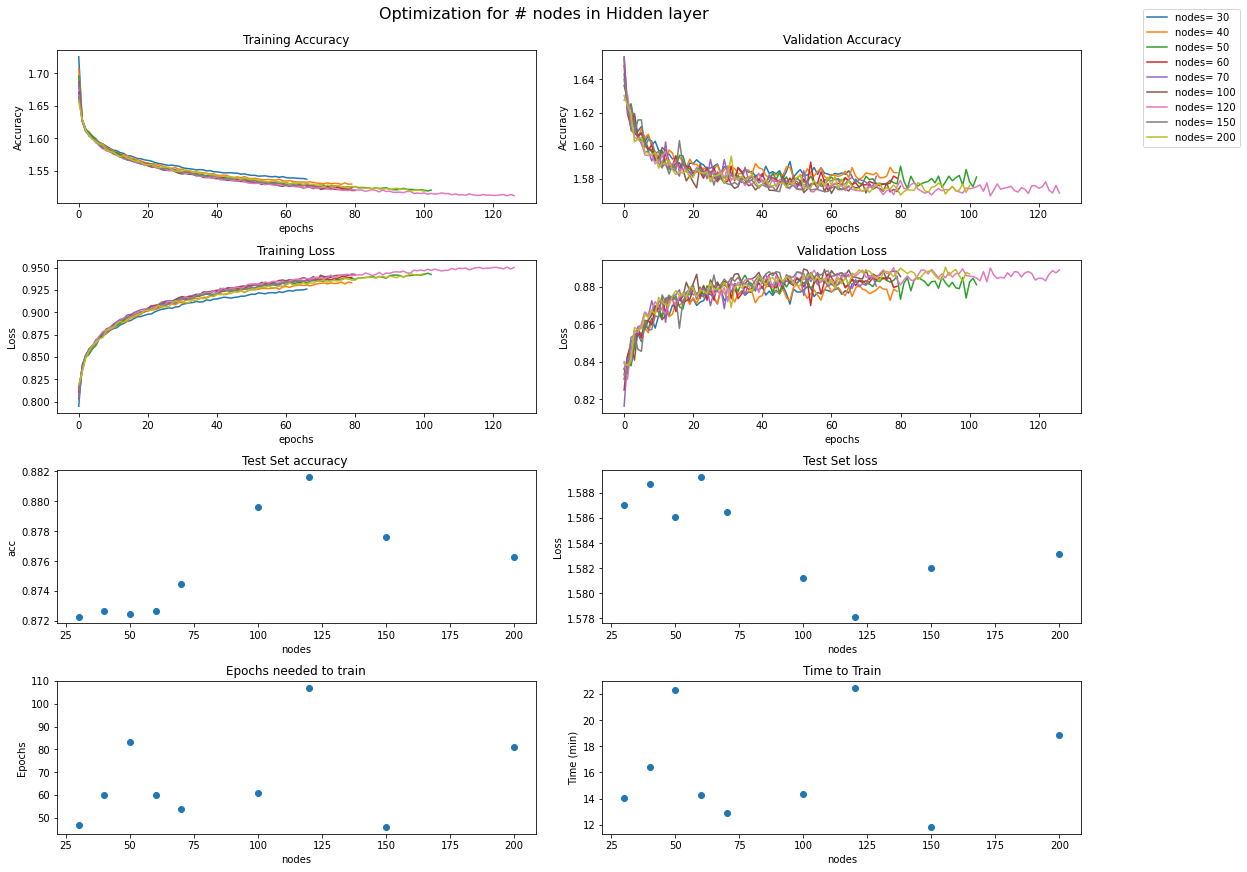

In [28]:
### Plotting 

fig, axs = plt.subplots(4, 2,figsize=(15,12), constrained_layout = True)
# fig.tight_layout()
# axs[0, 0].plot(x, y)
nhidden_arr = [30, 40, 50, 60, 70, 100, 120, 150, 200]
axs[0, 0].set_title('Training Accuracy')
axs[0, 1].set_title('Validation Accuracy')
axs[1, 0].set_title('Training Loss')
axs[1, 1].set_title('Validation Loss')
axs[2, 0].set_title('Test Set accuracy ')
axs[2, 1].set_title('Test Set loss ')
axs[3,0].set_title('Epochs needed to train')
axs[3,1].set_title('Time to Train')
n = len(nhidden_arr)
nepochs_arr = np.zeros(n)
for i in range(n):
    nhidden = nhidden_arr[i]
    key = str(nhidden)
    TrainLoss = Train_Loss_Mat[i,[Train_Loss_Mat[i,:]>0][0]]
    TrainAcc =Train_Acc_Mat[i,[Train_Acc_Mat[i,:]>0][0]]
    ValLoss = Val_Loss_Mat[i,[Val_Loss_Mat[i,:]>0][0]]
    ValAcc = Val_Acc_Mat[i,[Val_Acc_Mat[i,:]>0][0]]
    nepochs_trained = len(TrainLoss) 
    nepochs_arr[i] = nepochs_trained - 20;
    axs[0, 0].plot(TrainLoss )
    axs[0, 1].plot(ValLoss)
    axs[1,0].plot(TrainAcc)
    axs[1,1].plot(ValAcc, label ='nodes= '+ key)
    axs[0, 0].set(xlabel='epochs', ylabel = 'Accuracy')
    axs[0, 1].set(xlabel='epochs', ylabel = 'Accuracy')
    axs[1, 0].set(xlabel='epochs', ylabel = 'Loss')
    axs[1, 1].set(xlabel='epochs', ylabel = 'Loss')
axs[2,0].scatter(nhidden_arr, Test_Acc_Arr)
axs[2,1].scatter(nhidden_arr, Test_Loss_Arr)
axs[2, 0].set(xlabel='nodes', ylabel = 'acc')
axs[2, 1].set(xlabel='nodes', ylabel = 'Loss')
axs[3,0].scatter(nhidden_arr, nepochs_arr)
axs[3, 0].set(xlabel='nodes', ylabel = 'Epochs')
axs[3,1].scatter(nhidden_arr, Train_Time_Arr)
axs[3,1].set(xlabel = 'nodes', ylabel='Time (min)')
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Optimization for # nodes in Hidden layer', fontsize=16)

plt.show()

In [ ]:
# It is odd the at nodes = 50 it takes less epochs to train than at nodes = 120 but almost the same amount of time? 

In [23]:
Test_Acc_Arr[-2]

tensor(0.8776)

In [ ]:
# Next optimize over learning rates 